# XGBoost with Boston Dataset
  
  
  
  
  
  
#### Jeevan Kumar Ramakrishna

## Import Code

In [14]:
import sklearn.datasets as sk_data
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
# sns.set_context("paper")

from pdpbox import info_plots, get_dataset
from pdpbox import pdp
import xgboost as xgb
import sklearn.metrics as sk_met
import sklearn.model_selection as sk_mod
import sklearn.ensemble as sk_ens
sns.set(style="ticks", color_codes=True)
# sns.set_context('talk')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.options.display.float_format = '{:,.2f}'.format


In [335]:


from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



## Load Boston dataset

In [7]:
boston = sk_data.load_boston()
print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [8]:

data = pd.DataFrame(boston['data'])
data.columns = boston.feature_names
data['target'] = boston['target']
display(data.head())

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.01,18.00,2.31,0.00,0.54,6.58,65.20,4.09,1.00,296.00,15.30,396.90,4.98,24.00
1,0.03,0.00,7.07,0.00,0.47,6.42,78.90,4.97,2.00,242.00,17.80,396.90,9.14,21.60
2,0.03,0.00,7.07,0.00,0.47,7.18,61.10,4.97,2.00,242.00,17.80,392.83,4.03,34.70
3,0.03,0.00,2.18,0.00,0.46,7.00,45.80,6.06,3.00,222.00,18.70,394.63,2.94,33.40
4,0.07,0.00,2.18,0.00,0.46,7.15,54.20,6.06,3.00,222.00,18.70,396.90,5.33,36.20


In [287]:
data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
count,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00
mean,3.61,11.36,11.14,0.07,0.55,6.28,68.57,3.80,9.55,408.24,18.46,356.67,12.65,22.53
std,8.60,23.32,6.86,0.25,0.12,0.70,28.15,2.11,8.71,168.54,2.16,91.29,7.14,9.20
min,0.01,0.00,0.46,0.00,0.39,3.56,2.90,1.13,1.00,187.00,12.60,0.32,1.73,5.00
25%,0.08,0.00,5.19,0.00,0.45,5.89,45.02,2.10,4.00,279.00,17.40,375.38,6.95,17.02
50%,0.26,0.00,9.69,0.00,0.54,6.21,77.50,3.21,5.00,330.00,19.05,391.44,11.36,21.20
75%,3.68,12.50,18.10,0.00,0.62,6.62,94.07,5.19,24.00,666.00,20.20,396.23,16.96,25.00
max,88.98,100.00,27.74,1.00,0.87,8.78,100.00,12.13,24.00,711.00,22.00,396.90,37.97,50.00


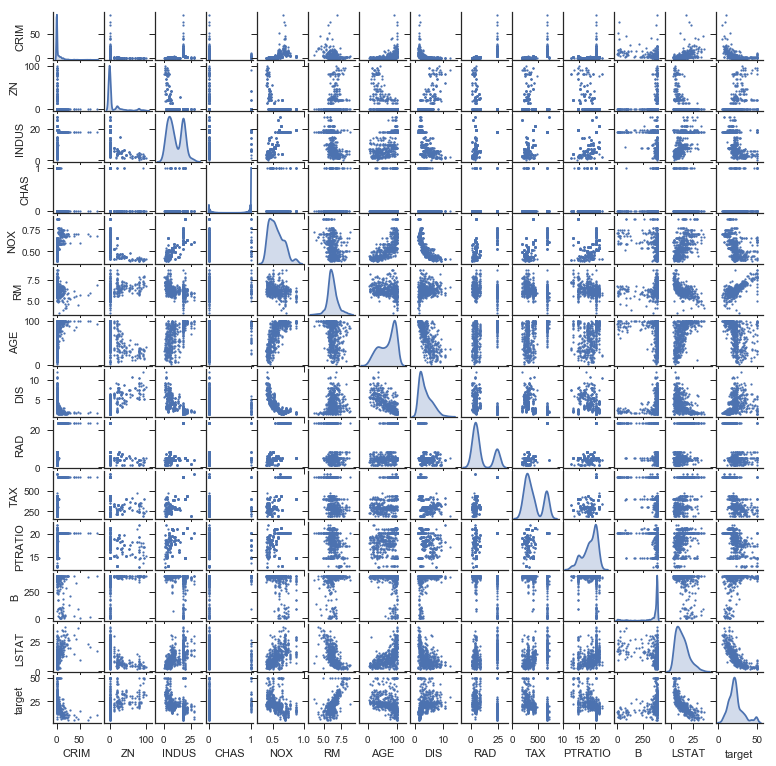

In [9]:
g = sns.pairplot(data, size=5, diag_kind="kde", 
                 diag_kws=dict(shade=True),
                 plot_kws=dict(s=5, edgecolor="b", linewidth=0))
plt.gcf().set_size_inches(10,10)

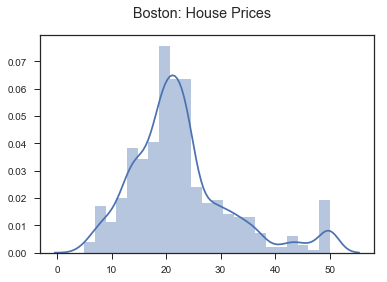

In [10]:
sns.distplot(boston['target'])
t = plt.gcf().suptitle('Boston: House Prices')

## Modelling

### Datasetup

In [11]:
train, test = sk_mod.train_test_split(data, train_size=0.8, random_state=0)

In [12]:
X_train, y_train = train.iloc[:,:-1], train.iloc[:,-1:]
X_test, y_test = test.iloc[:,:-1], test.iloc[:,-1:]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(404, 13) (404, 1)
(102, 13) (102, 1)


### XGBoost Initial Fit

In [292]:
xg_reg = xgb.XGBRegressor(objective='reg:linear', colsample_bytree=0.3, 
                          learning_rate=0.1, max_depth=5,
                         alpha=10, n_estimators=10)

In [296]:
xg_reg.fit(X_train, y_train)
y_preds = xg_reg.predict(X_test)
print('Mean Squared Error: {0:.4f}'.format(sk_met.mean_squared_error(y_test, y_preds)))

Mean Squared Error: 109.6910


### XGBoost GridSearch Fit

In [275]:
param_grid = {
    'objective':['reg:linear'],
    'n_estimators': [10, 100, 200],
    'max_depth': [5, 10, 15],
    'colsample_bytree': [0.1, 0.3, 0.5, 1.0],
    'colsample_bylevel': [0.1, 0.3, 0.5, 1.0],
    'learning_rate':[0.01, 0.05, 0.1],
    'subsample':[0.1,0.5, 0.75,1.0],
    'reg_lambda':[0]
}
gs_cv = sk_mod.GridSearchCV(cv=5, 
                            estimator=xg_reg, 
                            n_jobs=5, verbose=1, 
                            scoring=sk_met.make_scorer(sk_met.mean_squared_error, greater_is_better=False),
                            param_grid=param_grid)
gs_cv.fit(X=X_train, y=y_train)

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done 4413 tasks      | elapsed:   28.3s
[Parallel(n_jobs=5)]: Done 5920 tasks      | elapsed:   39.4s
[Parallel(n_jobs=5)]: Done 8020 tasks      | elapsed:  1.0min
[Parallel(n_jobs=5)]: Done 8640 out of 8640 | elapsed:  1.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=5,
       param_grid={'objective': ['reg:linear'], 'n_estimators': [10, 100, 200], 'max_depth': [5, 10, 15], 'colsample_bytree': [0.1, 0.3, 0.5, 1.0], 'colsample_bylevel': [0.1, 0.3, 0.5, 1.0], 'learning_rate': [0.01, 0.05, 0.1], 'subsample': [0.1, 0.5, 0.75, 1.0], 'reg_lambda': [0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_squared_error, greater_is_better=False),
       verbose=1)

In [276]:
gs_cv.best_estimator_

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree',
       colsample_bylevel=0.5, colsample_bytree=1.0, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=0, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.5)

In [277]:
pd.DataFrame(gs_cv.cv_results_).sort_values(by=['rank_test_score']).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bylevel,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_objective,param_reg_lambda,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
1233,0.072352,0.001422,0.001902,0.000042,0.5,1,0.05,5,200,reg:linear,0,0.5,"{'colsample_bylevel': 0.5, 'colsample_bytree':...",-6.200201,-7.342052,-6.538879,-12.666641,-6.410744,-7.835221,2.450217,1,-2.508344e-01,-2.557356e-01,-2.649077e-01,-2.640925e-01,-2.874047e-01,-2.645950e-01,1.255767e-02
1229,0.036947,0.001171,0.001478,0.000130,0.5,1,0.05,5,100,reg:linear,0,0.5,"{'colsample_bylevel': 0.5, 'colsample_bytree':...",-6.435454,-7.349209,-6.718688,-13.687652,-6.736199,-8.189028,2.769709,2,-8.978489e-01,-1.014886e+00,-9.955434e-01,-9.811666e-01,-1.028537e+00,-9.835963e-01,4.582564e-02
813,0.087654,0.001592,0.003164,0.000032,0.3,1,0.05,10,200,reg:linear,0,0.5,"{'colsample_bylevel': 0.3, 'colsample_bytree':...",-6.733359,-7.428506,-7.482481,-13.623505,-6.541157,-8.366308,2.658668,3,-8.248800e-03,-8.485641e-03,-7.954120e-03,-8.850803e-03,-8.220950e-03,-8.352063e-03,3.009312e-04
850,0.089491,0.002898,0.003149,0.000128,0.3,1,0.1,10,200,reg:linear,0,0.75,"{'colsample_bylevel': 0.3, 'colsample_bytree':...",-7.352439,-8.229364,-7.597241,-12.041710,-7.039928,-8.455632,1.837726,4,-5.218300e-07,-6.086730e-07,-5.449244e-07,-5.132503e-07,-4.553743e-07,-5.288104e-07,4.964149e-08
846,0.047241,0.000245,0.002035,0.000017,0.3,1,0.1,10,100,reg:linear,0,0.75,"{'colsample_bylevel': 0.3, 'colsample_bytree':...",-7.355649,-8.231340,-7.598065,-12.045371,-7.043143,-8.458208,1.838156,5,-2.169796e-04,-2.590113e-04,-2.373861e-04,-2.252338e-04,-1.850943e-04,-2.247410e-04,2.435855e-05


In [299]:
y_preds = gs_cv.best_estimator_.predict(X_test)
print('Mean Squared Error {0:.4f}'.format(sk_met.mean_squared_error(y_test, y_preds)))

Mean Squared Error 22.4238


Text(0.5,0.98,'XGBoost Feature Importance')

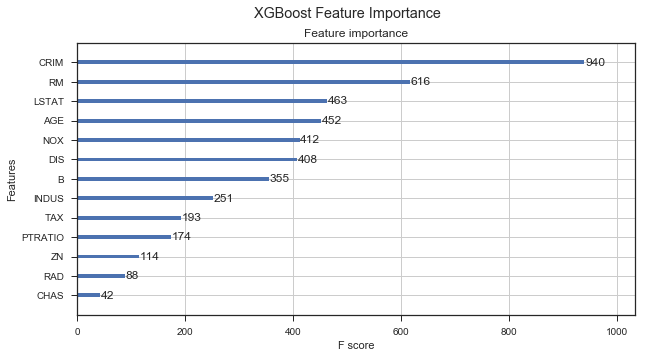

In [301]:
xgb.plot_importance(gs_cv.best_estimator_)
plt.gcf().set_size_inches(10, 5)
plt.gcf().suptitle('XGBoost Feature Importance')

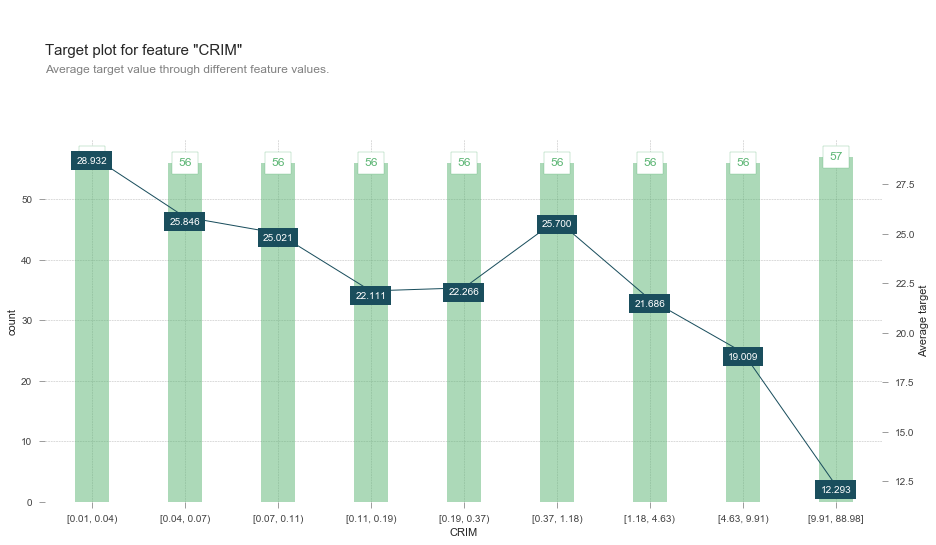

In [303]:
fig, axes, summary_df = info_plots.target_plot(
    df=data, feature='CRIM', feature_name='CRIM', target='target')


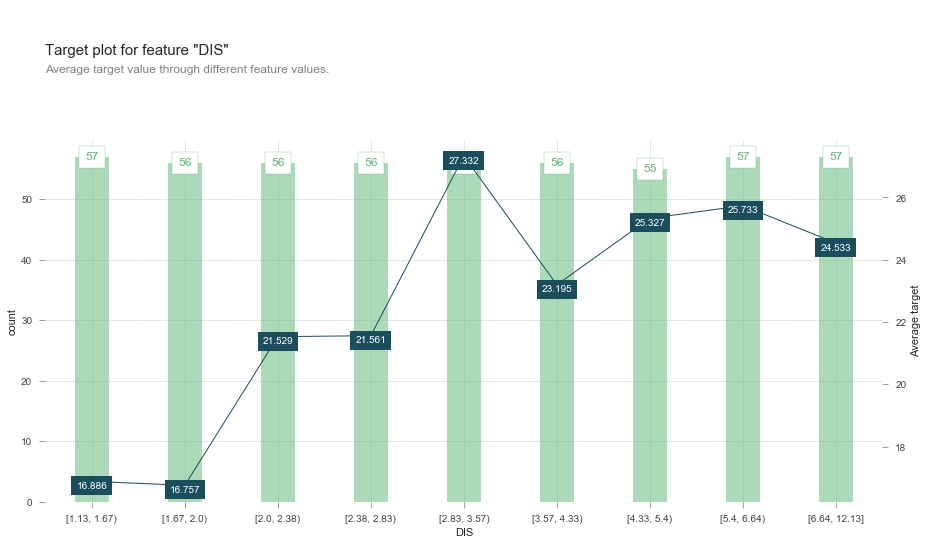

In [304]:
fig, axes, summary_df = info_plots.target_plot(
    df=data, feature='DIS', feature_name='DIS', target='target')


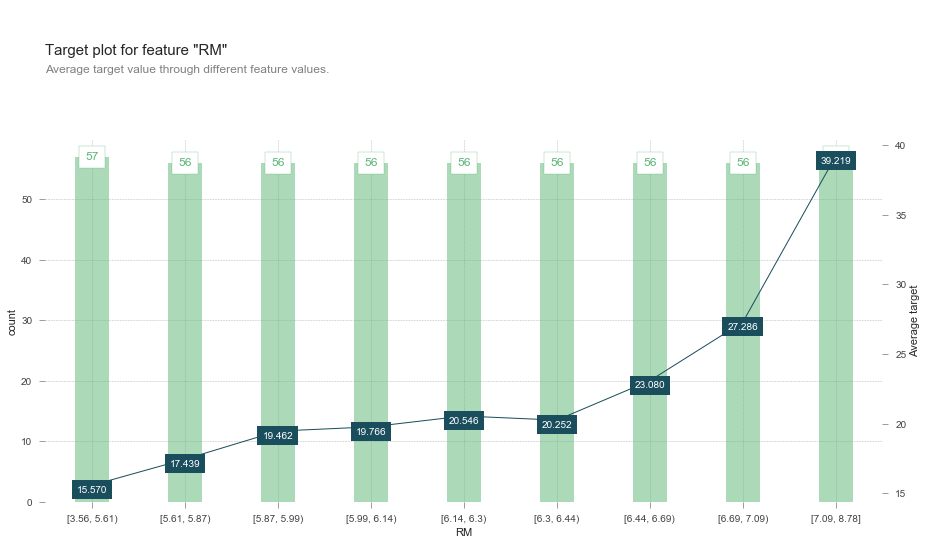

In [305]:
fig, axes, summary_df = info_plots.target_plot(
    df=data, feature='RM', feature_name='RM', target='target')


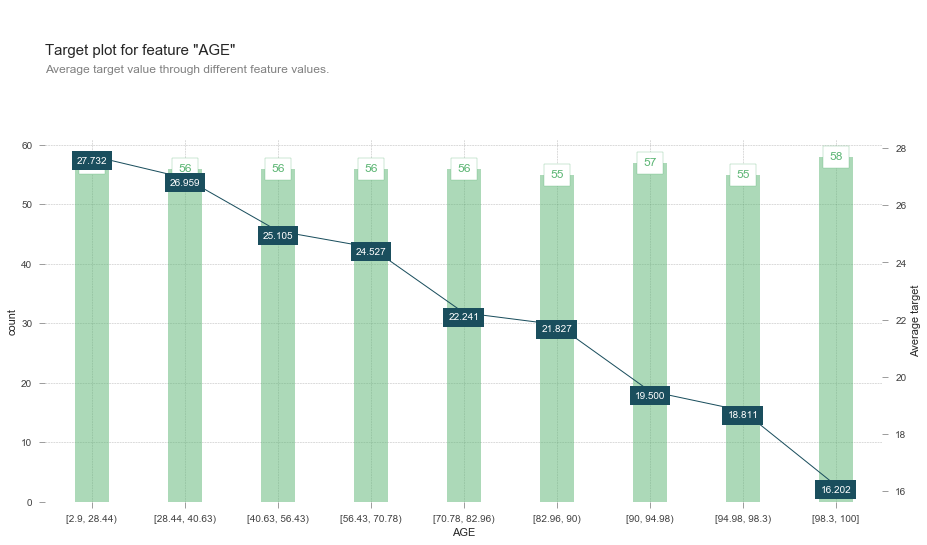

In [306]:
fig, axes, summary_df = info_plots.target_plot(
    df=data, feature='AGE', feature_name='AGE', target='target')


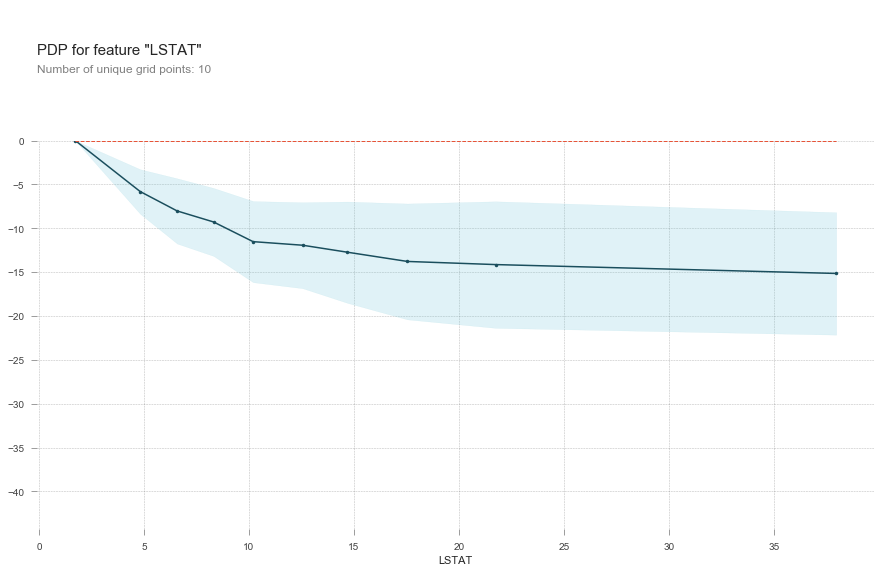

In [314]:
pdp_bmi = pdp.pdp_isolate(model=gs_cv.best_estimator_,
                          dataset=data,
                          model_features=data.columns[:-1],
                          feature='LSTAT', predict_kwds={})
fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_bmi, feature_name='LSTAT')


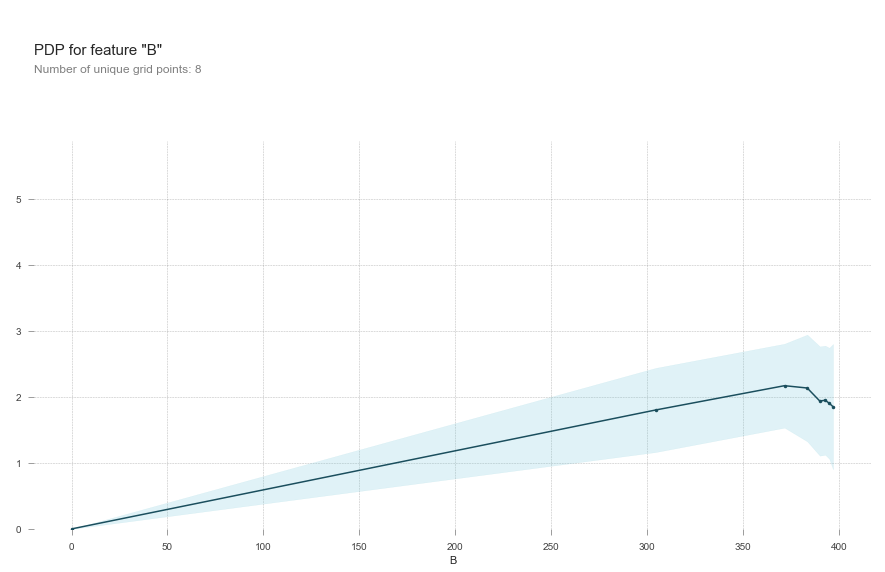

In [315]:
pdp_bmi = pdp.pdp_isolate(model=gs_cv.best_estimator_,
                          dataset=data,
                          model_features=data.columns[:-1],
                          feature='B', predict_kwds={})
fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_bmi, feature_name='B')


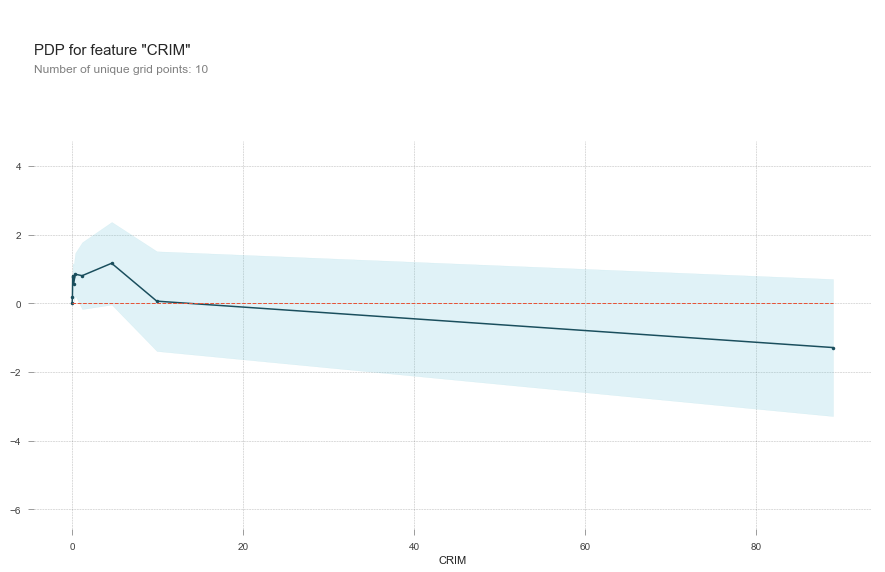

In [312]:
pdp_bmi = pdp.pdp_isolate(model=gs_cv.best_estimator_,
                          dataset=data,
                          model_features=data.columns[:-1],
                          feature='CRIM', predict_kwds={})
fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_bmi, feature_name='CRIM')


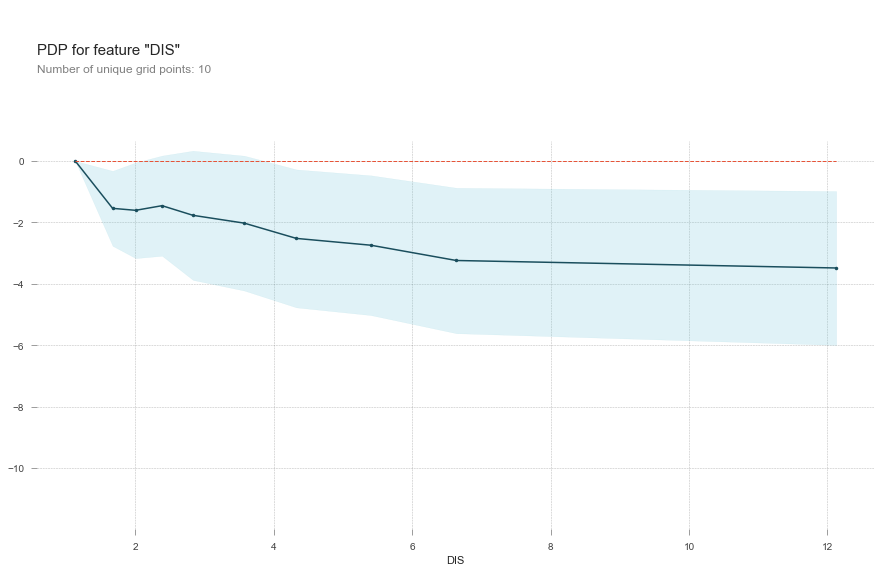

In [313]:
pdp_bmi = pdp.pdp_isolate(model=gs_cv.best_estimator_,
                          dataset=data,
                          model_features=data.columns[:-1],
                          feature='DIS')
fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_bmi, feature_name='DIS')


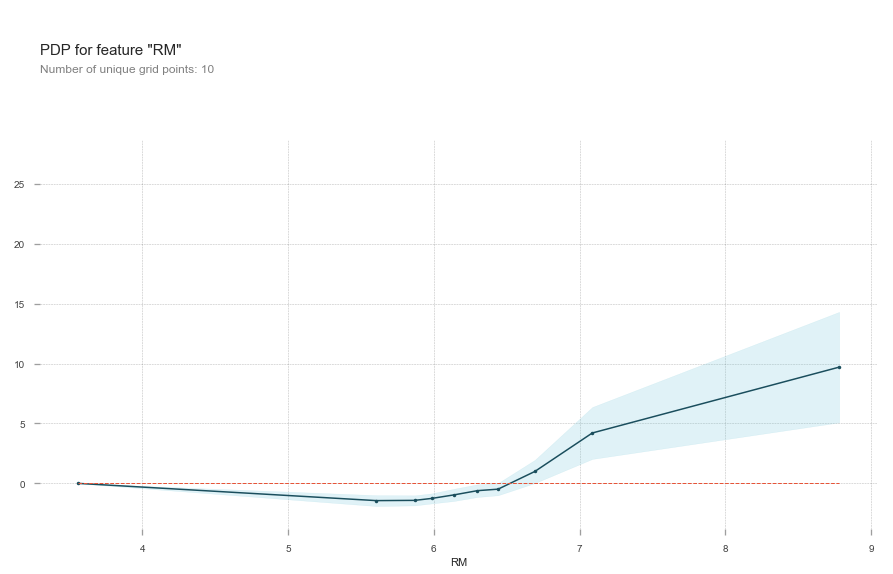

In [144]:
pdp_bmi = pdp.pdp_isolate(model=gs_cv.best_estimator_,
                          dataset=data,
                          model_features=data.columns[:-1],
                          feature='RM')
fig, axes = pdp.pdp_plot(pdp_isolate_out=pdp_bmi, feature_name='RM')


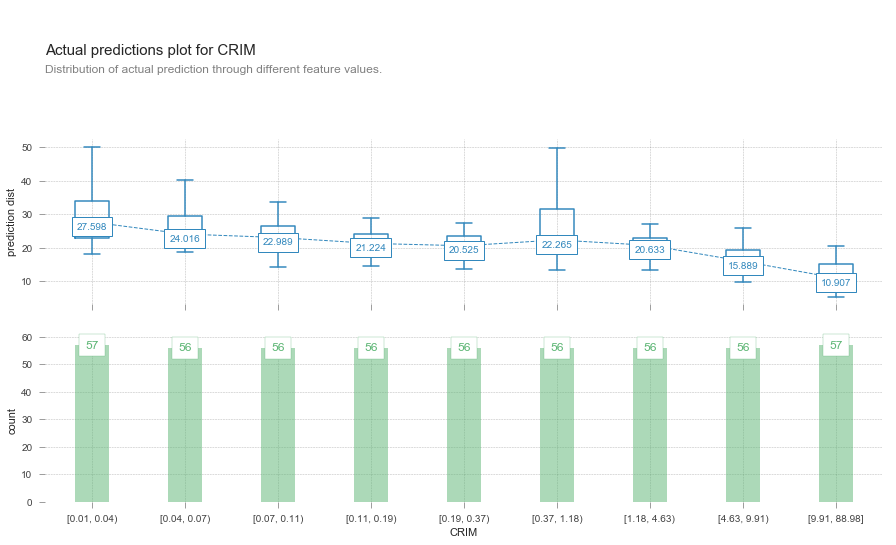

In [316]:
fig, axes, summary_df = info_plots.actual_plot(
    model=gs_cv.best_estimator_, X=data[data.columns[:-1]],
    feature='CRIM', feature_name='CRIM', predict_kwds={})

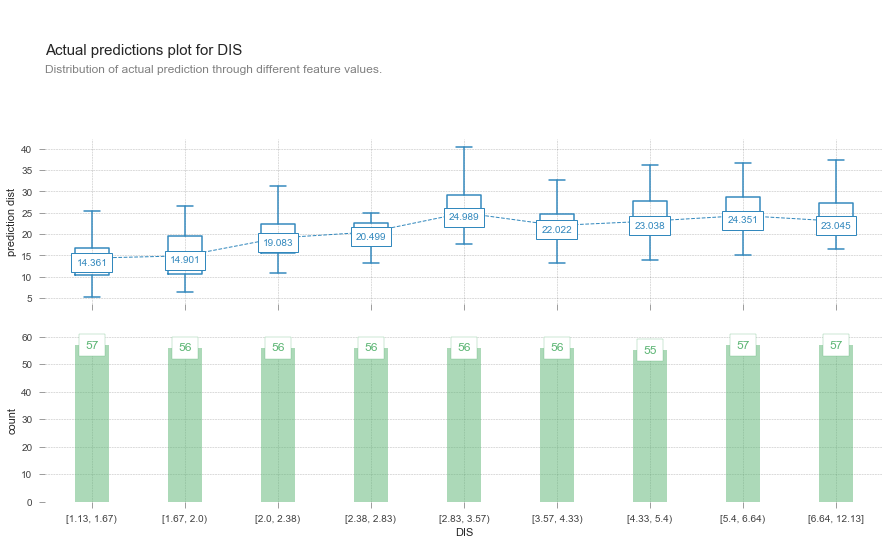

In [317]:
fig, axes, summary_df = info_plots.actual_plot(
    model=gs_cv.best_estimator_, X=data[data.columns[:-1]],
    feature='DIS', feature_name='DIS', predict_kwds={})

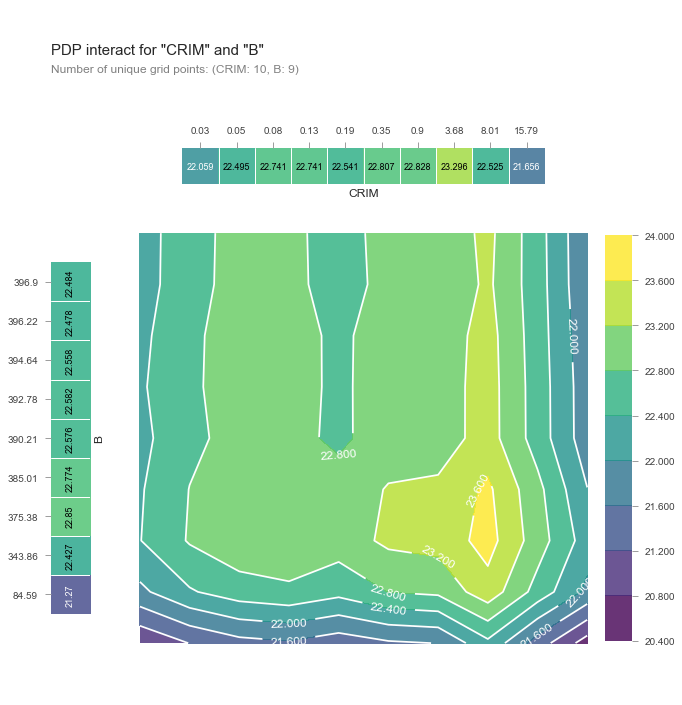

In [318]:


inter1 = pdp.pdp_interact(model=gs_cv.best_estimator_,
                          dataset=data,
                          model_features=data.columns[:-1],
                          features=['CRIM', 'B', 'LSTAT'],
                          num_grid_points=[10, 10, 10],
                          percentile_ranges=[(5, 95), (5, 95), (5, 95)])
fig, axes = pdp.pdp_interact_plot(pdp_interact_out=inter1,
                                  feature_names=['CRIM', 'B', 'LSTAT'],
                                  plot_type='contour',
                                  x_quantile=True,
                                  plot_pdp=True)


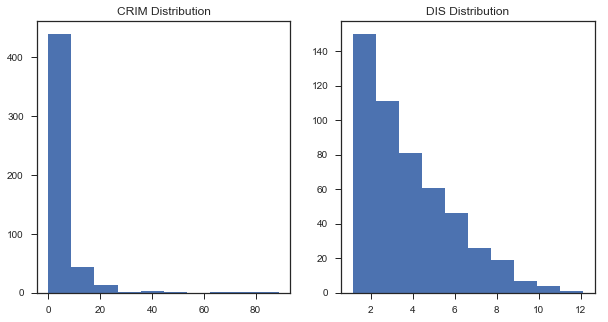

In [322]:
fig, ax = plt.subplots(1, 2)
ax[0].hist(data['CRIM'])
ax[0].set_title('CRIM Distribution')
_ = ax[1].hist(data['DIS'])
ax[1].set_title('DIS Distribution')
fig.set_size_inches(10, 5)

### Scikit-Learn Gradient Boosted Tree Fit

In [15]:
params = {
    'learning_rate': 0.1,
    'loss':'ls',
    'n_estimators':200,
    'subsample':1.0,
    'criterion':'friedman_mse',
    'max_depth':5,
    'random_state':0
    
}
gb_regr = sk_ens.GradientBoostingRegressor(**params)

In [16]:
gb_regr.fit(X=X_train, y=y_train)
y_preds = gb_regr.predict(X_test)
print('Mean Squared Error {0:.4f}'.format(sk_met.mean_squared_error(y_test, y_preds)))

Mean Squared Error 17.3264


### Sklearn Gradient Boosted Tree Grid Search based Fit

In [17]:
param_grid = {
    'n_estimators': [10, 100, 200],
    'max_depth': [3, 5, 10, 15],
    'learning_rate': [0.025, 0.05, 0.1, 0.15],
    'subsample': [1.0]
}
gs_cv_sk_reg = sk_mod.GridSearchCV(cv=5, 
                            estimator=gb_regr, 
                            n_jobs=5, verbose=1, 
                            scoring=sk_met.make_scorer(sk_met.mean_squared_error, greater_is_better=False),
                            param_grid=param_grid)
gs_cv_sk_reg.fit(X=X_train, y=y_train)
gs_cv_sk_reg.best_estimator_.fit(X=X_train, y=y_train)
y_preds = gs_cv_sk_reg.best_estimator_.predict(X_test)
print('Mean Squared Error {0:.4f}'.format(sk_met.mean_squared_error(y_test, y_preds)))

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  48 tasks      | elapsed:    4.5s


Mean Squared Error 16.9598


[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:   17.1s finished


In [26]:
results = pd.DataFrame(gs_cv_sk_reg.cv_results_)
display(results.sort_values(by=['rank_test_score'], ascending=True).head())
print('Best Param Estimators', results.sort_values(by=['rank_test_score'], ascending=True).head(1)[['params']].values[0][0])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
14,0.51,0.37,0.00,0.00,0.05,3,200,1.00,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est...",-6.08,-13.81,-6.48,-13.90,-7.87,-9.63,3.51,1,-1.28,-1.32,-1.35,-1.20,-1.25,-1.28,0.05
26,0.06,0.00,0.00,0.00,0.10,3,200,1.00,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",-6.36,-13.66,-6.68,-13.23,-9.02,-9.79,3.13,2,-0.43,-0.49,-0.45,-0.35,-0.49,-0.44,0.05
2,0.08,0.00,0.00,0.00,0.03,3,200,1.00,"{'learning_rate': 0.025, 'max_depth': 3, 'n_es...",-6.39,-13.76,-7.36,-13.85,-8.60,-10.00,3.19,3,-2.40,-2.46,-2.57,-2.35,-2.56,-2.47,0.09
38,0.34,0.34,0.00,0.00,0.15,3,200,1.00,"{'learning_rate': 0.15, 'max_depth': 3, 'n_est...",-6.26,-12.16,-6.57,-16.65,-8.34,-10.00,3.94,4,-0.13,-0.17,-0.18,-0.15,-0.17,-0.16,0.02
25,0.27,0.28,0.00,0.00,0.10,3,100,1.00,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",-6.39,-13.26,-7.28,-13.97,-9.17,-10.02,3.09,5,-1.31,-1.34,-1.34,-1.17,-1.35,-1.30,0.07


Best Param Estimators {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}


In [18]:
gs_cv_sk_reg.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

### Feature Importance

There are two ways to measure importance of a variable in ensemble models. 

1. the mean decrease of accuracy in predictions on the out of bag samples when a given variable is excluded from the model. 
2. the total decrease in node impurity that results from splits over that variable, averaged over all trees In the case of regression trees, the node impurity is measured by the training RSS or MSE, and for classification trees by the deviance.
     
According to Scikit-Learn's documentation, feature_importance is calculated by iterating through each of the estimators, and the each tree in the estimator and adding the array vector of feature importances. The feature importance is normalized twice, first based on the length of the stage and second based on the length of the estimators. Below is the scikit-learn's feature importance [code](https://github.com/scikit-learn/scikit-learn/blob/9dfe8768c8256baea176a57c6a9a2891b0a0690f/sklearn/ensemble/gradient_boosting.py#L1619)

```python
# normalized score across estimators
def feature_importances_(self):
    # ...
    total_sum = np.zeros((self.n_features_, ), dtype=np.float64)
    # for each stage in the estimator, and for each tree in stage
    # sum and normalize the importance
    # estimator > stage > tree
    for stage in self.estimators_: 
        stage_sum = sum(tree.tree_.compute_feature_importances(
            normalize=False) for tree in stage) / len(stage)
        total_sum += stage_sum

    importances = total_sum / len(self.estimators_)
    importances /= importances.sum()
    return importances

```
Iterate through the nodes of the tree. As long as you are not at a leaf node, calculate the weighted reduction in node purity from the split at this node, and attribute it to the feature that was split on. Below is code from sklearn implementation [tree importance](https://github.com/scikit-learn/scikit-learn/blob/9dfe8768c8256baea176a57c6a9a2891b0a0690f/sklearn/tree/_tree.pyx#L1062)

```python

cpdef compute_feature_importances(self):

    while node != end_node:
        if node.left_child != _TREE_LEAF:
            # ... and node.right_child != _TREE_LEAF:
            left = &nodes[node.left_child]
            right = &nodes[node.right_child]

            importance_data[node.feature] += (
                node.weighted_n_node_samples * node.impurity -
                left.weighted_n_node_samples * left.impurity -
                right.weighted_n_node_samples * right.impurity)
        node += 1

    importances /= nodes[0].weighted_n_node_samples
    return importances

```
__References:__  
1. [Introduction to Statistical Learning](https://www.amazon.com/Introduction-Statistical-Learning-Applications-Statistics/dp/1461471370) pages 319, 330
2. [StackExchange: Relative variable importance for Boosting](https://stats.stackexchange.com/questions/162162/relative-variable-importance-for-boosting)
3. [Feature Importance and Feature Selection With XGBoost in Python](https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/) by Jason Brownlee

Text(0.5,0.98,'Feature Importance Gradient Boosted Trees')

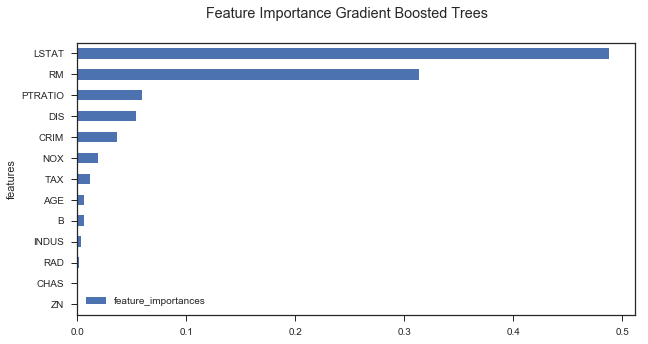

In [29]:
model = gs_cv_sk_reg.best_estimator_
fig, ax = plt.subplots(1, 1)
plot_df = pd.DataFrame({'feature_importances':model.feature_importances_, 'features':data.columns[:-1] })
plot_df = plot_df.set_index('features')
plot_df.sort_values(by=['feature_importances'], ascending=True, inplace=True)
plot_df.plot(kind='barh', ax=ax)
fig.set_size_inches(10,5)
fig.suptitle('Feature Importance Gradient Boosted Trees')

### Partial Dependence

Partial dependence plots (PDP) show the dependence between the target response and a set of ‘target’ features, marginalizing over the values of all other features (the ‘complement’ features). Intuitively, we can interpret the partial dependence as the expected target response [1] as a function of the ‘target’ features [2].

The partial dependence plot (PDP or PD plot) shows the marginal effect of a feature on the predicted outcome of a previously fit model (J. H. Friedman 200125). The prediction function is fixed at a few values of the chosen features and averaged over the other features.

A partial dependence plot can show if the relationship between the target and a feature is linear, monotonic or more complex. Applied to a linear regression model, partial dependence plots will always show a linear relationship, for example.

Our development starts with a curious coincidence.  One of the most used visualization  tools  of  black-box  models  is  the  partial  dependence  plot  (PDP)  proposed  in Friedman (2001).  Given the output $g(x)$ of a machine learning algorithm, the partial dependence of $g$ on a subset of variables $X_S$ is defined as (let $C$ be the complement set of $S$)

$$g_S(x_S) = E_{x_c} \left[ g(X_S, X_C) \right] = \int g(X_S, X_C)\space dP(X_c)$$

PDP $g_S$ is the expectation of g over `marginal` distribution of all variables other than $X_S$. This is different from the conditional expectation ($E_{x_c} \left[ g(X_S, X_C) | X_S = x_s\right]$), where the expectation is taken over the conditional distribution of $X_C$ given $X_S = x_s$. In practice, PDP is simply estimated by averaging over the training data $X_i, i = 1..n$
$$\bar{g_S}(x_S) = \frac{1}{n} \sum_{i=1}^{n}g(x_S, X_{C_i})$$
1. Greedy Function Approximation: A Gradient Boosting Machine Friedman 2001 [paper](https://statweb.stanford.edu/~jhf/ftp/trebst.pdf)
2. Causal Interpretation of Black-Box Models - Qingyuan Zhao and Trevor Hastie [paper](https://web.stanford.edu/~hastie/Papers/pdp_zhao.pdf)
3. https://christophm.github.io/interpretable-ml-book/pdp.html

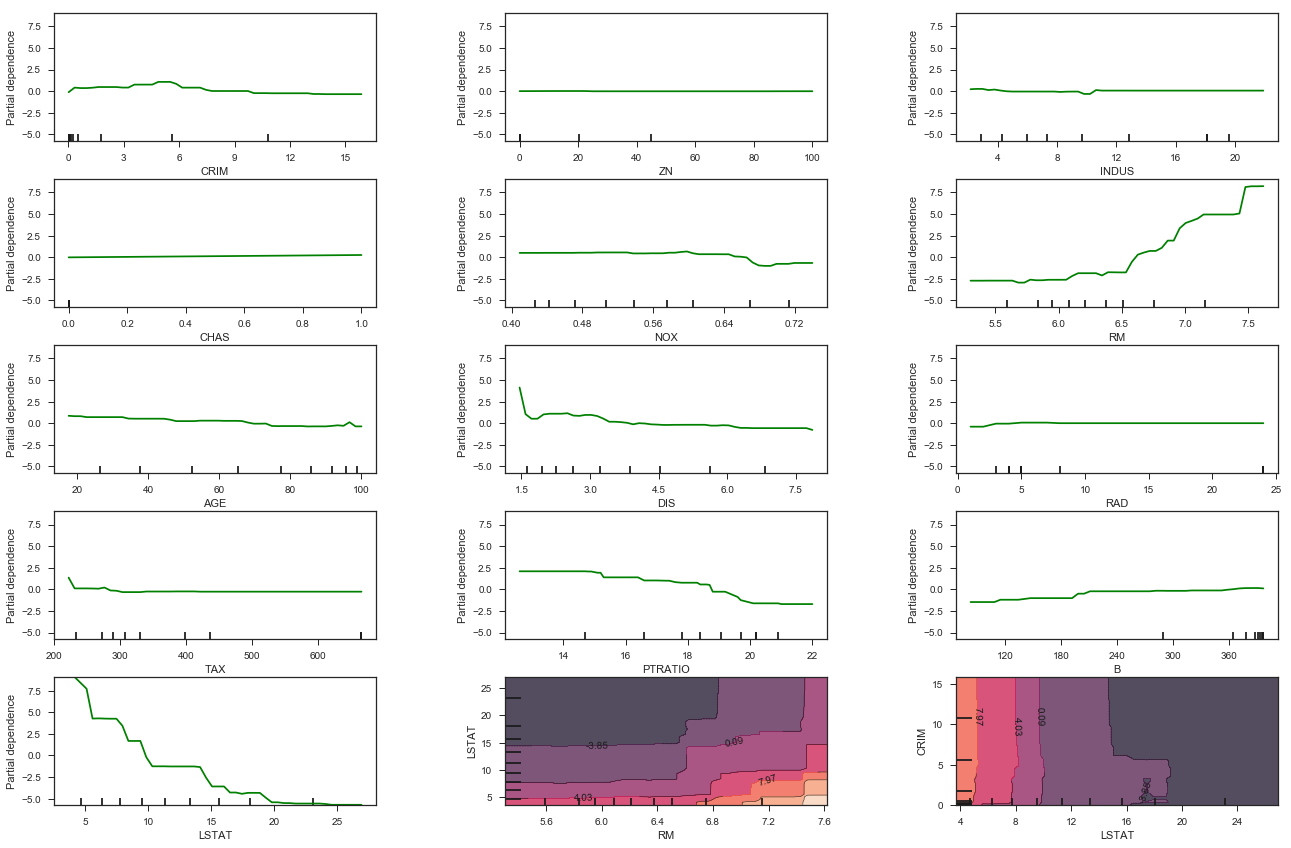

In [30]:
features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, (5, 12), (12,0)]
fig, axs = sk_ens.partial_dependence.plot_partial_dependence(model, data[data.columns[:-1]].values, 
                                   features,
                                   feature_names=data.columns[:-1],
                                   n_jobs=3, grid_resolution=50)
fig.set_size_inches(20, 20)

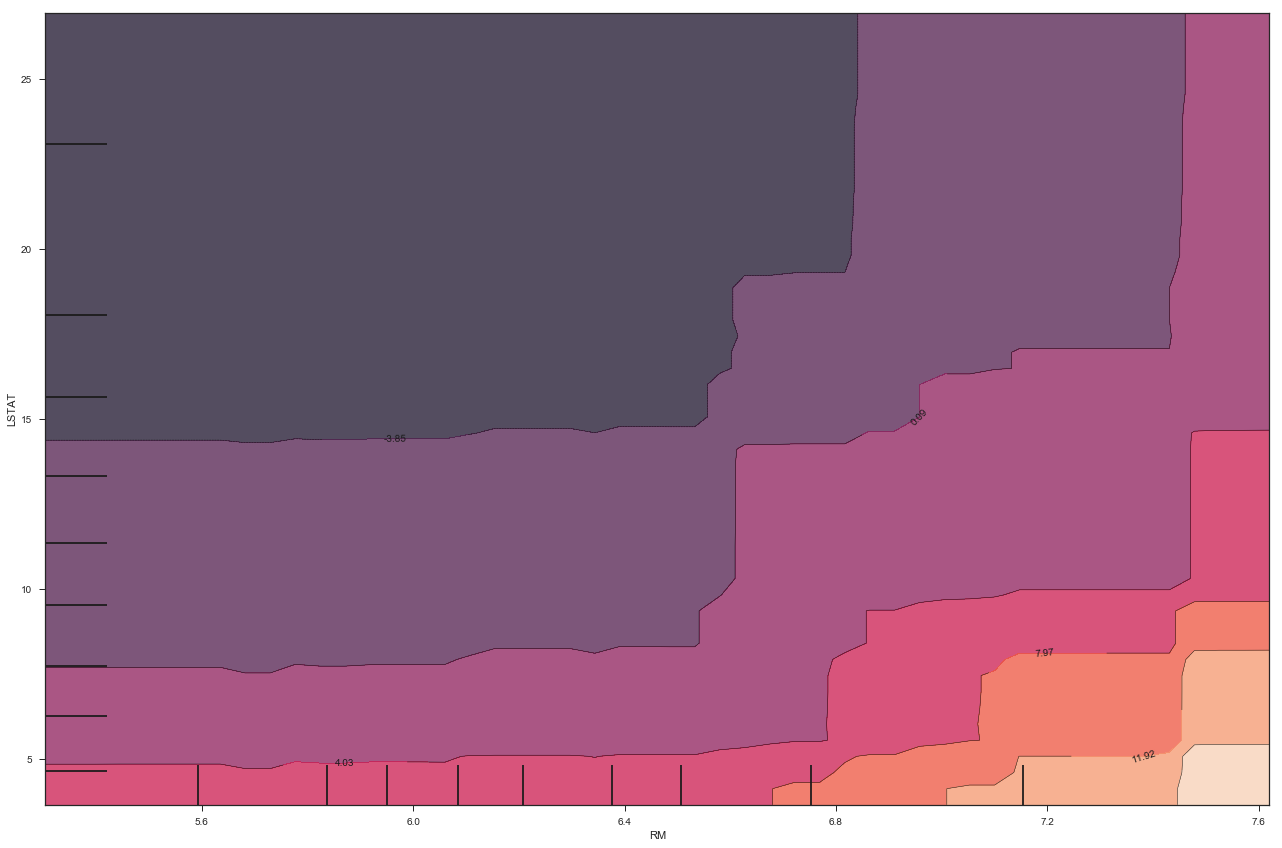

In [31]:
features = [(5, 12)]
fig, axs = sk_ens.partial_dependence.plot_partial_dependence(model, data[data.columns[:-1]].values, 
                                   features,
                                   feature_names=data.columns[:-1],
                                   n_jobs=3, grid_resolution=50)
fig.set_size_inches(20, 20)

In [32]:
data.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'target'],
      dtype='object')

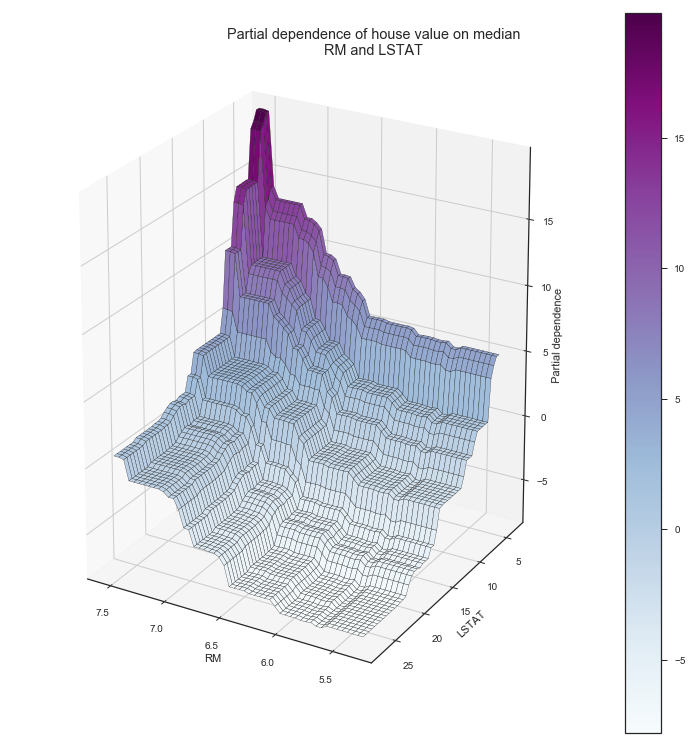

In [37]:
fig = plt.figure()

target_feature = (5, 12)
names = data.columns
pdp, axes = sk_ens.partial_dependence.partial_dependence(model, target_feature,
                               X=X_train, grid_resolution=50)
XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                       cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel(names[target_feature[0]])
ax.set_ylabel(names[target_feature[1]])
ax.set_zlabel('Partial dependence')
#  pretty init view
ax.view_init(elev=20, azim=120)
plt.colorbar(surf)
plt.suptitle('Partial dependence of house value on median\n'
             '{0} and {1}'.format(names[target_feature[0]], names[target_feature[1]]))
plt.subplots_adjust(top=0.9)
plt.gcf().set_size_inches(10, 10)

### Correlation Plots

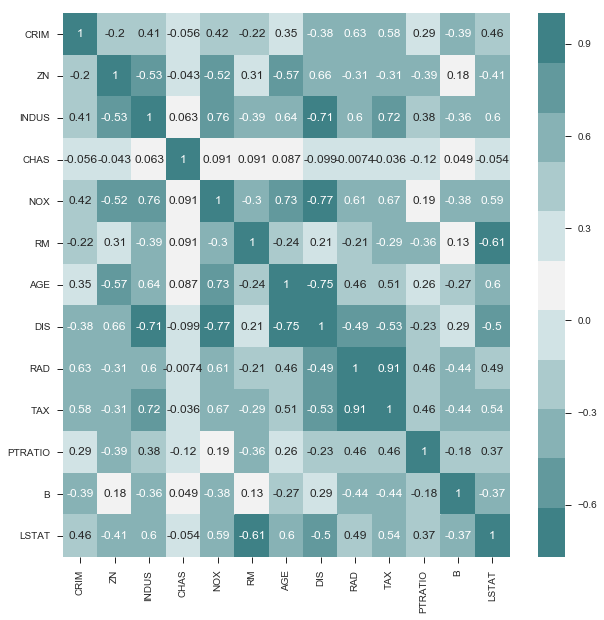

In [65]:
cmap = sns.diverging_palette(200, 200, l=50, n=11, center="light")
# cmap=None
ax = sns.heatmap(data[data.columns[:-1]].corr(), annot=True, cmap=cmap)
plt.gcf().set_size_inches(10, 10)